In [1]:
import lib.tf_silent
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
from lib.pinn import PINN
from lib.network import Network
from lib.optimizer import L_BFGS_B

/Users/neelarun/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
import tensorflow as tf

def u0(txy, c=4, k=2, sd=0.5):

    t = txy[..., 0, None]  # Time variable
    x = txy[..., 1, None]  # X spatial variable
    y = txy[..., 2, None]  # Y spatial variable

    # Calculate the wave equation in 2D
    z = k * (x + y) - (c * k) * t  # Combine x and y into the wave function
    return tf.sin(z) * tf.exp(-(0.5 * z / sd) ** 2)

def du0_dt(txy):

    with tf.GradientTape() as g:
        g.watch(txy)
        u = u0(txy)
    du_dt = g.batch_jacobian(u, txy)[..., 0]  # Get the derivative w.r.t. time
    return du_dt


In [3]:
# number of training samples
num_train_samples = 1000
# number of test samples
num_test_samples = 500
# build a core network model
network = Network.build()
network.summary()
    # build a PINN model
pinn = PINN(network).build()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,505 (5.88 KB)

 Trainable params: 1,505 (5.88 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:

# create training input
txy_eqn = np.random.rand(num_train_samples, 3)
txy_eqn[..., 0] = 4 * txy_eqn[..., 0]                # t = 0 ~ +4
txy_eqn[..., 1] = 2 * txy_eqn[..., 1] - 1            # x = -1 ~ +1
txy_eqn[..., 2] = 2 * txy_eqn[..., 2] - 1            # y = -1 ~ +1

txy_ini = np.random.rand(num_train_samples, 3)
txy_ini[..., 0] = 0                                  # t = 0 (initial time)
txy_ini[..., 1] = 2 * txy_ini[..., 1] - 1            # x = -1 ~ +1
txy_ini[..., 2] = 2 * txy_ini[..., 2] - 1            # y = -1 ~ +1

txy_bnd = np.random.rand(num_train_samples, 3)
txy_bnd[..., 0] = 4 * txy_bnd[..., 0]                # t = 0 ~ +4
txy_bnd[..., 1] = 2 * np.round(txy_bnd[..., 1]) - 1  # x = -1 or +1 (boundary in x)
txy_bnd[..., 2] = 2 * np.round(txy_bnd[..., 2]) - 1  # y = -1 or +1 (boundary in y)

# create training output
u_zero = np.zeros((num_train_samples, 1))            # Output for zero solutions
u_ini = u0(tf.constant(txy_ini)).numpy()             # Initial condition output u(t=0, x, y)
du_dt_ini = du0_dt(tf.constant(txy_ini)).numpy()     # Initial time derivative du/dt (t=0, x, y)


In [5]:
# train the model using L-BFGS-B algorithm
# Update x_train to include txy (t, x, y) inputs
x_train = [txy_eqn, txy_ini, txy_bnd]
y_train = [u_zero, u_ini, du_dt_ini, u_zero]

# Train the model using L-BFGS-B optimizer
lbfgs = L_BFGS_B(model=pinn, x_train=x_train, y_train=y_train)
lbfgs.fit()

# Predict u(t, x, y) distribution
t_flat = np.linspace(0, 4, num_test_samples)    # Time dimension
x_flat = np.linspace(-1, 1, num_test_samples)   # X dimension
y_flat = np.linspace(-1, 1, num_test_samples)   # Y dimension

# Create meshgrid for t, x, and y
t, x, y = np.meshgrid(t_flat, x_flat, y_flat)

# Prepare input for prediction
txy = np.stack([t.flatten(), x.flatten(), y.flatten()], axis=-1)


# Make predictions using the trained model
u = network.predict(txy, batch_size=num_test_samples)
u = u.reshape(t.shape)  # Reshape to match the t, x, y grid shape


Optimizer: L-BFGS-B (maxiter=15000)
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 273s 18ms/step
250000/250000 ━━━━━━━━━━━━━━━━━━━━ 105s 412us/step


In [6]:
u.shape

(500, 500, 500)

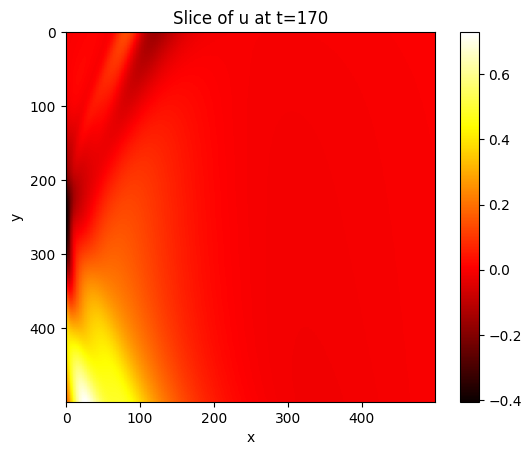

In [7]:
# Choose a particular value of t
t_index = 170

# Extract the (x, y) slice for the chosen t value
u_slice = u[:, :, t_index]

plt.imshow(u_slice, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title(f'Slice of u at t={t_index}')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [8]:
import imageio
# List to hold images for GIF
images = []
# Set constant color limits
vmin = np.min(u)  # Minimum value in u
vmax = np.max(u)  # Maximum value in u
# Generate images for each slice of u
for t in range(500):
    plt.figure(figsize=(6, 6))
    plt.imshow(u[:, :, t], cmap='hot', interpolation='nearest')
    plt.title(f'Slice of u at t={t}')
    plt.xlabel('x')
    plt.ylabel('y')
    cbar = plt.colorbar()
    cbar.set_label('Intensity')
    # Save the current figure as an image
    plt.savefig(f'slice_{t}.png')  # Save as PNG
    plt.close()  # Close the figure to free memory

    # Append the saved image to the list
    images.append(imageio.imread(f'slice_{t}.png'))

# Create a GIF from the images
imageio.mimsave('animation_linear_t500.gif', images, duration=5)

print("GIF created successfully: animation.gif")

/var/folders/qh/t3f57b9s7jv65xm86nwjv_sw0000gn/T/ipykernel_52709/2680748846.py:21: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'slice_{t}.png'))


GIF created successfully: animation.gif


IndexError: tuple index out of range

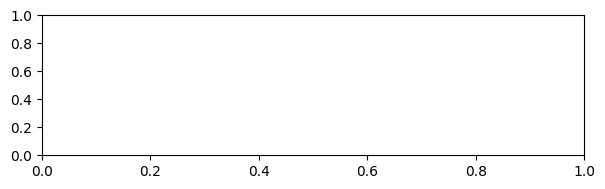

In [10]:
# with Dirichlet Boundary Conditions
fig = plt.figure(figsize=(7,4))
gs = GridSpec(2, 3)
plt.subplot(gs[0, :])
vmin, vmax = -0.5, +0.5
plt.pcolormesh(t, x, u, cmap='rainbow', norm=Normalize(vmin=vmin, vmax=vmax))
plt.xlabel('t')
plt.ylabel('x')
#cbar = plt.colorbar(pad=0.05, aspect=10)
cbar.set_label('u(t,x)')
cbar.mappable.set_clim(vmin, vmax)
t_cross_sections = [1, 2, 3]
for i, t_cs in enumerate(t_cross_sections):
    plt.subplot(gs[1, i])
    tx = np.stack([np.full(t_flat.shape, t_cs), x_flat], axis=-1)
    u = network.predict(tx, batch_size=num_test_samples)
    plt.plot(x_flat, u)
    plt.title('t={}'.format(t_cs))
    plt.xlabel('x')
    plt.ylabel('u(t,x)')
plt.tight_layout()
# plt.savefig('result_img_dirichlet.png', transparent=True)
plt.show()
